In [1]:
import numpy as np # linear algebra
import pandas as pd
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from fastai.vision import *
from fastai import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import shutil
import torch

rn_seed=1
np.random.seed(rn_seed)
# Any results you write to the current directory are saved as output.
from fastai.vision.all import *

In [2]:
path = Path('../../storage/facial')

In [3]:
path.ls()

(#5) [Path('../../storage/facial/IdLookupTable.csv'),Path('../../storage/facial/train'),Path('../../storage/facial/training.csv'),Path('../../storage/facial/test.csv'),Path('../../storage/facial/test')]

In [4]:
id_lookup = pd.read_csv(path/'IdLookupTable.csv')
train_csv = pd.read_csv(path/'training.csv')
test_csv = pd.read_csv(path/'test.csv')

In [5]:
for c in train_csv.columns:
    if(train_csv[c].dtype!='object'):
        train_csv[c]=train_csv[c].fillna(train_csv[c].median())

In [6]:
def row2points(r): 
  a = np.reshape(r[0:30].values, (15,2)).astype(np.float64)
  return a

def str2img(row):
  imarr = np.fromstring(row.Image, dtype='int32', sep=' ').astype(np.int32)
  i = Image.fromarray(imarr.reshape(-1, 96)).convert('P')
  return PILImage(i)


In [7]:
data = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_x=str2img,
    get_y=row2points,
    splitter=RandomSplitter(valid_pct=0.15, seed=42),
)

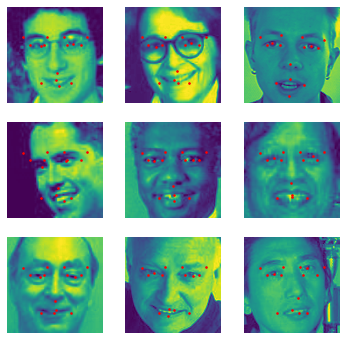

In [8]:
dls = data.dataloaders(train_csv)
dls.show_batch(max_n=9, figsize=(6,6))

In [9]:
learn = cnn_learner(dls,resnet152)

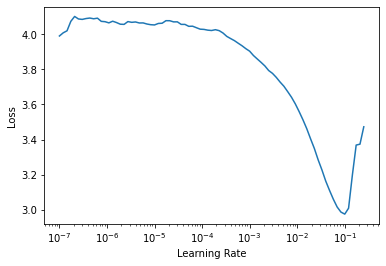

In [10]:
lrmin, lrsteep = learn.lr_find()

In [11]:
lrmin, lrsteep

(0.010000000149011612, 0.02290867641568184)

In [12]:
learn.fine_tune(15, 0.01 )

epoch,train_loss,valid_loss,time
0,0.985715,0.050124,00:49


epoch,train_loss,valid_loss,time
0,0.059488,0.028041,01:07
1,0.047585,0.040948,01:05
2,0.092880,0.562342,01:06
3,0.178411,1.150369,01:06
4,0.155658,0.053987,01:05
5,0.123224,0.014877,01:05
6,0.083150,0.013589,01:06
7,0.044578,0.109938,01:05
8,0.025637,0.035765,01:06
9,0.013633,0.017096,01:05


In [14]:
learn = cnn_learner(dls,resnet152)
learn.fine_tune(15)

epoch,train_loss,valid_loss,time
0,2.191879,0.339421,00:48


epoch,train_loss,valid_loss,time
0,0.869380,0.086404,01:06
1,0.661697,0.051204,01:06
2,0.473324,0.062646,01:06
3,0.331784,0.113973,01:06
4,0.236514,0.076800,01:06
5,0.177904,1.316616,01:05
6,0.138223,1.106229,01:05
7,0.108026,0.030788,01:06
8,0.083203,0.043377,01:05
9,0.071420,0.047814,01:06


In [16]:
learn1 = cnn_learner(dls,resnet152)
learn1.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,3.208468,0.780915,00:48
1,1.922964,0.213105,00:48
2,0.975671,0.054218,00:49
3,0.507911,0.020881,00:48
4,0.271256,0.013761,00:48
5,0.151961,0.007933,00:48
6,0.093839,0.006934,00:48
7,0.065242,0.004358,00:48
8,0.051653,0.003820,00:48
9,0.047378,0.003615,00:48


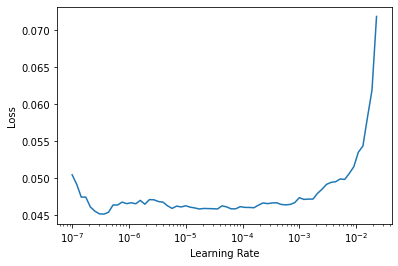

In [19]:
learn1.unfreeze()
lrmin, lrsteep = learn1.lr_find()

In [20]:
learn1.fit_one_cycle(40,lrsteep)

epoch,train_loss,valid_loss,time
0,0.047050,0.003571,01:06
1,0.048000,0.003610,01:06
2,0.047181,0.003575,01:06
3,0.046048,0.003514,01:06
4,0.047001,0.003508,01:06
5,0.046247,0.003513,01:06
6,0.046041,0.003474,01:06
7,0.047034,0.003452,01:06
8,0.047199,0.003477,01:06
9,0.046776,0.003454,01:06


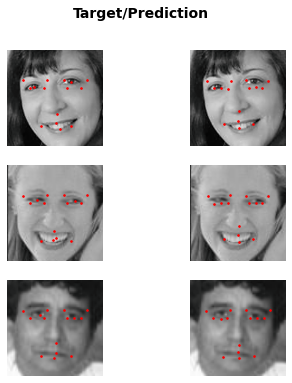

In [21]:
learn.show_results(figsize=(6,6))

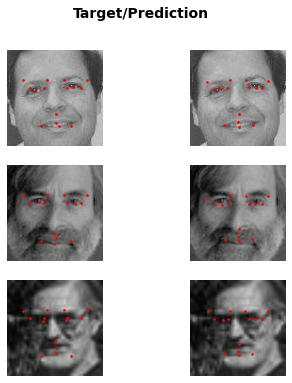

In [22]:
learn1.show_results(figsize=(6,6))

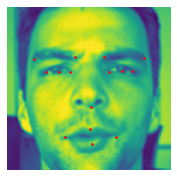

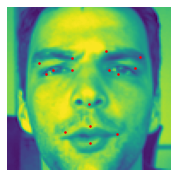

In [25]:
def show_pred(i, df, learn):
    pic = PILImage(str2img(df.iloc[i]))
    (pred, t1, t2) = learn.predict(pic) #don't know what t1 and t2 are
    pic = TensorImage(pic)
    screen = pic.show()
    pred.show(ctx=screen)
    
show_pred(5, test_csv, learn)
show_pred(5, test_csv, learn1)

In [26]:
preds = [learn1.predict(PILImage(str2img(test_csv.iloc[idx])))[0] for idx in range(len(test_csv))]
results = [x.reshape(30).numpy() for x in preds]
results = pd.DataFrame(results)
results.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,67.638130,38.921124,31.162941,39.163719,58.378487,39.905586,70.510101,39.880692,37.683594,37.804291,...,48.548641,51.886276,60.210148,75.326721,33.488052,74.085426,46.431854,67.456009,48.256897,81.151962
1,64.939865,37.945747,31.437691,37.585007,57.944092,38.997826,71.555000,39.780670,36.505882,38.556122,...,48.469471,59.086403,61.407814,73.408791,34.228695,74.743149,48.032272,71.574142,46.911896,80.161133
2,61.700684,36.705654,33.608971,42.894138,57.832649,39.817741,64.055008,34.667717,40.680603,40.461040,...,48.918579,53.729500,61.542938,68.465485,40.873955,67.678223,50.667793,67.868988,47.435650,77.516068
3,66.035011,37.807999,29.028618,39.975891,57.748016,39.528645,74.866920,39.382858,35.264248,38.882149,...,48.883518,57.853020,62.592133,74.331711,35.336113,76.362877,49.812088,69.307541,49.208069,81.254616
4,65.368500,35.544464,26.093513,37.287590,59.443977,38.509933,73.089348,41.035782,38.492161,38.117691,...,44.149540,56.790665,63.390781,75.760277,32.615326,74.736069,46.488750,71.221786,47.429737,82.410522


In [27]:
results.shape

names = [
         'left_eye_center_x','left_eye_center_y',
         'right_eye_center_x','right_eye_center_y',
         'left_eye_inner_corner_x','left_eye_inner_corner_y',
         'left_eye_outer_corner_x','left_eye_outer_corner_y',
         'right_eye_inner_corner_x','right_eye_inner_corner_y',
         'right_eye_outer_corner_x','right_eye_outer_corner_y',
         'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
         'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
         'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
         'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
         'nose_tip_x','nose_tip_y',
         'mouth_left_corner_x','mouth_left_corner_y',
         'mouth_right_corner_x','mouth_right_corner_y',
         'mouth_center_top_lip_x','mouth_center_top_lip_y',
         'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y'
]
dicty = {}
for x in range(30):
  dicty[x] = names[x]
print(dicty)
results.rename(dicty, axis='columns', inplace=True)
results['ImageId'] = range(1, 1783+1)
#results.head()

{0: 'left_eye_center_x', 1: 'left_eye_center_y', 2: 'right_eye_center_x', 3: 'right_eye_center_y', 4: 'left_eye_inner_corner_x', 5: 'left_eye_inner_corner_y', 6: 'left_eye_outer_corner_x', 7: 'left_eye_outer_corner_y', 8: 'right_eye_inner_corner_x', 9: 'right_eye_inner_corner_y', 10: 'right_eye_outer_corner_x', 11: 'right_eye_outer_corner_y', 12: 'left_eyebrow_inner_end_x', 13: 'left_eyebrow_inner_end_y', 14: 'left_eyebrow_outer_end_x', 15: 'left_eyebrow_outer_end_y', 16: 'right_eyebrow_inner_end_x', 17: 'right_eyebrow_inner_end_y', 18: 'right_eyebrow_outer_end_x', 19: 'right_eyebrow_outer_end_y', 20: 'nose_tip_x', 21: 'nose_tip_y', 22: 'mouth_left_corner_x', 23: 'mouth_left_corner_y', 24: 'mouth_right_corner_x', 25: 'mouth_right_corner_y', 26: 'mouth_center_top_lip_x', 27: 'mouth_center_top_lip_y', 28: 'mouth_center_bottom_lip_x', 29: 'mouth_center_bottom_lip_y'}


In [28]:
# need to go from point values as COLUMNS to point values as ROWS
sorted_results = results.melt(id_vars='ImageId', value_vars=names).sort_values(by=['ImageId'])
sorted_results['variable'] = pd.CategoricalIndex(sorted_results['variable'], names)
sorted_results.rename(columns={'variable':'FeatureName', 'value':'Location'}, inplace=True)
sorted_results.sort_values(by=['ImageId','FeatureName'], inplace=True)
sorted_results.set_index(['ImageId','FeatureName'], inplace=True)
#sortrez.head(30)

In [29]:
# and then put predictions the way the submission file wants it

id_lookup
id_lookup.set_index(['ImageId','FeatureName'], inplace=True)
id_lookup.head()

combo = id_lookup.join(sorted_results, on=['ImageId','FeatureName'], lsuffix='remove')
combo.drop(columns='Locationremove', inplace=True)
combo.reset_index(inplace=True)
combo[['RowId','ImageId','FeatureName','Location']]
combo['Location'] = combo['Location'].clip(lower=0, upper=96)
combo.describe()
#combo

,ImageId,RowId,Location
count,27124.000000,27124.000000,27124.000000
mean,608.372880,13562.500000,49.019162
std,492.180504,7830.168687,16.507703
min,1.000000,1.000000,11.847190
25%,227.000000,6781.750000,37.395658
50%,454.000000,13562.500000,47.556576
75%,936.000000,20343.250000,64.006508
max,1783.000000,27124.000000,94.720413


In [31]:
combo[['RowId','Location']].to_csv('submission2.csv', index=False)
# ran with like 70 epochs and got ~top third of leaderboard
# 3.76639